In [1]:
##########CREATE MODEL INCEPTIONResNet V2#######################################
from keras.layers import Input, merge, Dropout, Dense, Flatten, Activation
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from keras import backend as K
from keras.utils.data_utils import get_file

"""
Implementation of Inception Network v4 [Inception Network v4 Paper](http://arxiv.org/pdf/1602.07261v1.pdf) in Keras.
"""

TH_BACKEND_TH_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_th_dim_ordering_th_kernels.h5"
TH_BACKEND_TF_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_tf_dim_ordering_th_kernels.h5"
TF_BACKEND_TF_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_tf_dim_ordering_tf_kernels.h5"
TF_BACKEND_TH_DIM_ORDERING = "https://github.com/titu1994/Inception-v4/releases/download/v1.2/inception_v4_weights_th_dim_ordering_tf_kernels.h5"


def conv_block(x, nb_filter, nb_row, nb_col, border_mode='same', subsample=(1, 1), bias=False):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    x = Convolution2D(nb_filter, nb_row, nb_col, subsample=subsample, border_mode=border_mode, bias=bias)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    return x


def inception_stem(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    x = conv_block(input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
    x = conv_block(x, 32, 3, 3, border_mode='valid')
    x = conv_block(x, 64, 3, 3)

    x1 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(x)
    x2 = conv_block(x, 96, 3, 3, subsample=(2, 2), border_mode='valid')

    x = merge([x1, x2], mode='concat', concat_axis=channel_axis)

    x1 = conv_block(x, 64, 1, 1)
    x1 = conv_block(x1, 96, 3, 3, border_mode='valid')

    x2 = conv_block(x, 64, 1, 1)
    x2 = conv_block(x2, 64, 1, 7)
    x2 = conv_block(x2, 64, 7, 1)
    x2 = conv_block(x2, 96, 3, 3, border_mode='valid')

    x = merge([x1, x2], mode='concat', concat_axis=channel_axis)

    x1 = conv_block(x, 192, 3, 3, subsample=(2, 2), border_mode='valid')
    x2 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(x)

    x = merge([x1, x2], mode='concat', concat_axis=channel_axis)
    return x


def inception_A(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    a1 = conv_block(input, 96, 1, 1)

    a2 = conv_block(input, 64, 1, 1)
    a2 = conv_block(a2, 96, 3, 3)

    a3 = conv_block(input, 64, 1, 1)
    a3 = conv_block(a3, 96, 3, 3)
    a3 = conv_block(a3, 96, 3, 3)

    a4 = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(input)
    a4 = conv_block(a4, 96, 1, 1)

    m = merge([a1, a2, a3, a4], mode='concat', concat_axis=channel_axis)
    return m


def inception_B(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    b1 = conv_block(input, 384, 1, 1)

    b2 = conv_block(input, 192, 1, 1)
    b2 = conv_block(b2, 224, 1, 7)
    b2 = conv_block(b2, 256, 7, 1)

    b3 = conv_block(input, 192, 1, 1)
    b3 = conv_block(b3, 192, 7, 1)
    b3 = conv_block(b3, 224, 1, 7)
    b3 = conv_block(b3, 224, 7, 1)
    b3 = conv_block(b3, 256, 1, 7)

    b4 = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(input)
    b4 = conv_block(b4, 128, 1, 1)

    m = merge([b1, b2, b3, b4], mode='concat', concat_axis=channel_axis)
    return m


def inception_C(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    c1 = conv_block(input, 256, 1, 1)

    c2 = conv_block(input, 384, 1, 1)
    c2_1 = conv_block(c2, 256, 1, 3)
    c2_2 = conv_block(c2, 256, 3, 1)
    c2 = merge([c2_1, c2_2], mode='concat', concat_axis=channel_axis)

    c3 = conv_block(input, 384, 1, 1)
    c3 = conv_block(c3, 448, 3, 1)
    c3 = conv_block(c3, 512, 1, 3)
    c3_1 = conv_block(c3, 256, 1, 3)
    c3_2 = conv_block(c3, 256, 3, 1)
    c3 = merge([c3_1, c3_2], mode='concat', concat_axis=channel_axis)

    c4 = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(input)
    c4 = conv_block(c4, 256, 1, 1)

    m = merge([c1, c2, c3, c4], mode='concat', concat_axis=channel_axis)
    return m


def reduction_A(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    r1 = conv_block(input, 384, 3, 3, subsample=(2, 2), border_mode='valid')

    r2 = conv_block(input, 192, 1, 1)
    r2 = conv_block(r2, 224, 3, 3)
    r2 = conv_block(r2, 256, 3, 3, subsample=(2, 2), border_mode='valid')

    r3 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(input)

    m = merge([r1, r2, r3], mode='concat', concat_axis=channel_axis)
    return m


def reduction_B(input):
    if K.image_dim_ordering() == "th":
        channel_axis = 1
    else:
        channel_axis = -1

    r1 = conv_block(input, 192, 1, 1)
    r1 = conv_block(r1, 192, 3, 3, subsample=(2, 2), border_mode='valid')

    r2 = conv_block(input, 256, 1, 1)
    r2 = conv_block(r2, 256, 1, 7)
    r2 = conv_block(r2, 320, 7, 1)
    r2 = conv_block(r2, 320, 3, 3, subsample=(2, 2), border_mode='valid')

    r3 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid')(input)

    m = merge([r1, r2, r3], mode='concat', concat_axis=channel_axis)
    return m


def create_inception_v4(nb_classes=1001, load_weights=True):
    '''
    Creates a inception v4 network

    :param nb_classes: number of classes.txt
    :return: Keras Model with 1 input and 1 output
    '''

    if K.image_dim_ordering() == 'th':
        init = Input((3, 299, 299))
    else:
        init = Input((299, 299, 3))

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    x = inception_stem(init)

    # 4 x Inception A
    for i in range(4):
        x = inception_A(x)

    # Reduction A
    x = reduction_A(x)

    # 7 x Inception B
    for i in range(7):
        x = inception_B(x)

    # Reduction B
    x = reduction_B(x)

    # 3 x Inception C
    for i in range(3):
        x = inception_C(x)

    # Average Pooling
    x = AveragePooling2D((8, 8))(x)

    # Dropout
    x = Dropout(0.8)(x)
    x = Flatten()(x)

    # Output
    out = Dense(output_dim=nb_classes, activation='softmax')(x)

    model = Model(init, out, name='Inception-v4')

    if load_weights:
        if K.backend() == "theano":
            if K.image_dim_ordering() == "th":
                weights = get_file('inception_v4_weights_th_dim_ordering_th_kernels.h5', TH_BACKEND_TH_DIM_ORDERING,
                                   cache_subdir='models')
            else:
                weights = get_file('inception_v4_weights_tf_dim_ordering_th_kernels.h5', TH_BACKEND_TF_DIM_ORDERING,
                                   cache_subdir='models')
        else:
            if K.image_dim_ordering() == "th":
                weights = get_file('inception_v4_weights_th_dim_ordering_tf_kernels.h5', TF_BACKEND_TH_DIM_ORDERING,
                                   cache_subdir='models')
            else:
                weights = get_file('inception_v4_weights_tf_dim_ordering_tf_kernels.h5', TH_BACKEND_TF_DIM_ORDERING,
                                   cache_subdir='models')

        model.load_weights(weights)
        print("Model weights loaded.")

    return model


if __name__ == "__main__":
    # from keras.utils.visualize_util import plot

    inception_v4 = create_inception_v4(load_weights=True)
    inception_v4.summary()

    # plot(inception_v4, to_file="Inception-v4.png", show_shapes=True)


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, padding="valid", strides=(2, 2))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, padding="valid", strides=(1, 1))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), use_bias=False, padding="same", strides=(1, 1))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(448, (3, 1), use_bias=False, padding="same", strides=(1, 1))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 3), use_bias=False, padding="same", strides=(1, 1))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:130: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:132: UserWarning: Update your `AveragePooling2D` call to the Keras 2 API: `AveragePooling2D((3, 3), padding="same", strides=(1, 1))`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:135: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merg

171802624/171799220 [==============================] - 9s 0us/step
Model weights loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________

In [2]:
from keras.preprocessing.image  import ImageDataGenerator, img_to_array, load_img 
from keras.models  import Sequential
from keras.layers  import Dropout,  Flatten,  Dense
from keras.applications import InceptionV3
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical 
import time
import os
import numpy as np 
import math
import  matplotlib.pyplot  as  plt

img_width = 299
img_height = 299
batch_size = 64 
epochs = 80
nb_train = 4000
nb_validation = 1200
nb_test = 1200
nb_classes = 4
nb_FC = 1024

PATH_TO_FE = "Inception" 
train_dir  =  "balanced_dataset/train"
validation_dir = "balanced_dataset/validation" 
test_dir  =  "balanced_dataset/test" 


In [3]:
#PREPROCESSING + FEATURE EXTRACTION

datagen  =  ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory( 
    train_dir,
    target_size = (img_width, img_height), 
    batch_size = batch_size,
    class_mode  =  None,  
    shuffle = False, 
    interpolation  =  'lanczos')

validation_generator = datagen.flow_from_directory( 
    validation_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None,
    shuffle=False, 
    interpolation  =  'lanczos')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle=False, 
    interpolation  =  'lanczos')

###########Feature Extraction (FE)#########################
#Train
max_size_train = int(math.ceil(nb_train / batch_size)) 
train_features = inception_v4.predict_generator(train_generator, max_size_train)
np.save('InceptionV4/InceptionV4_FE_train_1.npy',  train_features)
#Validation
max_size_validation = int(math.ceil(nb_validation / batch_size)) 
validation_features  =  inception_v4.predict_generator(validation_generator,  max_size_validation) 
np.save('InceptionV4/InceptionV4_FE_validation_1.npy',  validation_features)
#Test
max_size_test = int(math.ceil(nb_test / batch_size)) 
test_features  =  inception_v4.predict_generator(test_generator,  max_size_test)

#Labels Extraction
train_labels  =  train_generator.classes  
train_labels = to_categorical(train_labels, num_classes=nb_classes) 
validation_labels  =  validation_generator.classes  
validation_labels  =  to_categorical(validation_labels, num_classes=nb_classes) 
test_labels  =  test_generator.classes  
test_labels  =  to_categorical(test_labels, num_classes=nb_classes) 

#Save Features
train_data = np.load('InceptionV4/InceptionV4_FE_train_1.npy') 
validation_data  =  np.load('InceptionV4/InceptionV4_FE_validation_1.npy')


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [5]:
#Top Model Classificator
model = Sequential() 
#model.add(Flatten(input_shape=train_data.shape[1:]))
#model.add(Flatten())
model.add(Dense(nb_FC,  activation='relu', input_shape=train_data.shape[1:])) 
model.add(Dropout(0.5))
model.add(Dense(nb_classes,  activation='softmax'))


In [6]:
#Compile models
model.compile(
    optimizer = RMSprop(lr=2e-5),
    loss='categorical_crossentropy',  
    metrics=['accuracy'])


In [16]:
#Train model
epochs = 1000 
history = model.fit(
    train_data, 
    train_labels,
    epochs=epochs,  
    batch_size=batch_size, 
    validation_data=(validation_data, validation_labels))


Train on 4000 samples, validate on 1200 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.5992 - acc: 0.7710 - val_loss: 0.8203 - val_acc: 0.7117
Epoch 2/1000
4000/4000 [==============================] - 0s 48us/step - loss: 0.6035 - acc: 0.7702 - val_loss: 0.8204 - val_acc: 0.7092
Epoch 3/1000
4000/4000 [==============================] - 0s 47us/step - loss: 0.5980 - acc: 0.7732 - val_loss: 0.8211 - val_acc: 0.7108
Epoch 4/1000
4000/4000 [==============================] - 0s 46us/step - loss: 0.6048 - acc: 0.7700 - val_loss: 0.8202 - val_acc: 0.7100
Epoch 5/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.6007 - acc: 0.7655 - val_loss: 0.8200 - val_acc: 0.7142
Epoch 6/1000
4000/4000 [==============================] - 0s 42us/step - loss: 0.6007 - acc: 0.7712 - val_loss: 0.8206 - val_acc: 0.7142
Epoch 7/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5917 - acc: 0.7777 - val_loss: 0.8205 - val_acc: 

4000/4000 [==============================] - 0s 41us/step - loss: 0.5998 - acc: 0.7705 - val_loss: 0.8197 - val_acc: 0.7133
Epoch 61/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5957 - acc: 0.7685 - val_loss: 0.8201 - val_acc: 0.7100
Epoch 62/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5963 - acc: 0.7722 - val_loss: 0.8209 - val_acc: 0.7125
Epoch 63/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5937 - acc: 0.7717 - val_loss: 0.8197 - val_acc: 0.7117
Epoch 64/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5912 - acc: 0.7730 - val_loss: 0.8197 - val_acc: 0.7125
Epoch 65/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5992 - acc: 0.7650 - val_loss: 0.8201 - val_acc: 0.7100
Epoch 66/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5927 - acc: 0.7687 - val_loss: 0.8206 - val_acc: 0.7125
Epoch 67/1000
4000/4000 [=======================

4000/4000 [==============================] - 0s 42us/step - loss: 0.5970 - acc: 0.7745 - val_loss: 0.8192 - val_acc: 0.7117
Epoch 120/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5971 - acc: 0.7738 - val_loss: 0.8204 - val_acc: 0.7133
Epoch 121/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5968 - acc: 0.7708 - val_loss: 0.8202 - val_acc: 0.7117
Epoch 122/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5904 - acc: 0.7807 - val_loss: 0.8203 - val_acc: 0.7108
Epoch 123/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.6039 - acc: 0.7690 - val_loss: 0.8198 - val_acc: 0.7125
Epoch 124/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5961 - acc: 0.7705 - val_loss: 0.8197 - val_acc: 0.7125
Epoch 125/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5952 - acc: 0.7750 - val_loss: 0.8196 - val_acc: 0.7125
Epoch 126/1000
4000/4000 [================

4000/4000 [==============================] - 0s 42us/step - loss: 0.5950 - acc: 0.7732 - val_loss: 0.8202 - val_acc: 0.7125
Epoch 179/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5992 - acc: 0.7735 - val_loss: 0.8201 - val_acc: 0.7108
Epoch 180/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5933 - acc: 0.7715 - val_loss: 0.8201 - val_acc: 0.7125
Epoch 181/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5973 - acc: 0.7705 - val_loss: 0.8201 - val_acc: 0.7133
Epoch 182/1000
4000/4000 [==============================] - 0s 42us/step - loss: 0.5968 - acc: 0.7752 - val_loss: 0.8194 - val_acc: 0.7133
Epoch 183/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5858 - acc: 0.7760 - val_loss: 0.8196 - val_acc: 0.7108
Epoch 184/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5975 - acc: 0.7702 - val_loss: 0.8200 - val_acc: 0.7158
Epoch 185/1000
4000/4000 [================

4000/4000 [==============================] - 0s 41us/step - loss: 0.5929 - acc: 0.7750 - val_loss: 0.8200 - val_acc: 0.7125
Epoch 238/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5938 - acc: 0.7745 - val_loss: 0.8193 - val_acc: 0.7142
Epoch 239/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5882 - acc: 0.7758 - val_loss: 0.8204 - val_acc: 0.7125
Epoch 240/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5918 - acc: 0.7728 - val_loss: 0.8201 - val_acc: 0.7125
Epoch 241/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5935 - acc: 0.7768 - val_loss: 0.8200 - val_acc: 0.7125
Epoch 242/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.6012 - acc: 0.7732 - val_loss: 0.8200 - val_acc: 0.7150
Epoch 243/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.6010 - acc: 0.7687 - val_loss: 0.8191 - val_acc: 0.7142
Epoch 244/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5957 - acc: 0.7740 - val_loss: 0.8196 - val_acc: 0.7142
Epoch 297/1000
4000/4000 [==============================] - 0s 42us/step - loss: 0.5888 - acc: 0.7785 - val_loss: 0.8196 - val_acc: 0.7150
Epoch 298/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5881 - acc: 0.7770 - val_loss: 0.8194 - val_acc: 0.7142
Epoch 299/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5861 - acc: 0.7812 - val_loss: 0.8194 - val_acc: 0.7108
Epoch 300/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5973 - acc: 0.7758 - val_loss: 0.8187 - val_acc: 0.7125
Epoch 301/1000
4000/4000 [==============================] - 0s 43us/step - loss: 0.5876 - acc: 0.7760 - val_loss: 0.8195 - val_acc: 0.7117
Epoch 302/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5897 - acc: 0.7760 - val_loss: 0.8202 - val_acc: 0.7100
Epoch 303/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5867 - acc: 0.7722 - val_loss: 0.8194 - val_acc: 0.7150
Epoch 356/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5915 - acc: 0.7780 - val_loss: 0.8190 - val_acc: 0.7150
Epoch 357/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5961 - acc: 0.7758 - val_loss: 0.8194 - val_acc: 0.7133
Epoch 358/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5954 - acc: 0.7720 - val_loss: 0.8195 - val_acc: 0.7133
Epoch 359/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5846 - acc: 0.7788 - val_loss: 0.8190 - val_acc: 0.7133
Epoch 360/1000
4000/4000 [==============================] - 0s 42us/step - loss: 0.5930 - acc: 0.7712 - val_loss: 0.8192 - val_acc: 0.7133
Epoch 361/1000
4000/4000 [==============================] - 0s 43us/step - loss: 0.5911 - acc: 0.7750 - val_loss: 0.8196 - val_acc: 0.7142
Epoch 362/1000
4000/4000 [================

4000/4000 [==============================] - 0s 42us/step - loss: 0.5913 - acc: 0.7760 - val_loss: 0.8186 - val_acc: 0.7108
Epoch 415/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5916 - acc: 0.7715 - val_loss: 0.8188 - val_acc: 0.7150
Epoch 416/1000
4000/4000 [==============================] - 0s 42us/step - loss: 0.5932 - acc: 0.7758 - val_loss: 0.8203 - val_acc: 0.7150
Epoch 417/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5863 - acc: 0.7772 - val_loss: 0.8189 - val_acc: 0.7133
Epoch 418/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5910 - acc: 0.7728 - val_loss: 0.8189 - val_acc: 0.7158
Epoch 419/1000
4000/4000 [==============================] - 0s 45us/step - loss: 0.5884 - acc: 0.7772 - val_loss: 0.8192 - val_acc: 0.7133
Epoch 420/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5860 - acc: 0.7775 - val_loss: 0.8191 - val_acc: 0.7133
Epoch 421/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5923 - acc: 0.7772 - val_loss: 0.8185 - val_acc: 0.7133
Epoch 474/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5894 - acc: 0.7682 - val_loss: 0.8186 - val_acc: 0.7167
Epoch 475/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5914 - acc: 0.7775 - val_loss: 0.8178 - val_acc: 0.7142
Epoch 476/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5896 - acc: 0.7725 - val_loss: 0.8189 - val_acc: 0.7142
Epoch 477/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5863 - acc: 0.7798 - val_loss: 0.8198 - val_acc: 0.7167
Epoch 478/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5908 - acc: 0.7715 - val_loss: 0.8193 - val_acc: 0.7142
Epoch 479/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5886 - acc: 0.7785 - val_loss: 0.8188 - val_acc: 0.7150
Epoch 480/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5898 - acc: 0.7795 - val_loss: 0.8182 - val_acc: 0.7142
Epoch 533/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5890 - acc: 0.7777 - val_loss: 0.8185 - val_acc: 0.7142
Epoch 534/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5913 - acc: 0.7730 - val_loss: 0.8181 - val_acc: 0.7142
Epoch 535/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5879 - acc: 0.7730 - val_loss: 0.8190 - val_acc: 0.7150
Epoch 536/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5843 - acc: 0.7788 - val_loss: 0.8183 - val_acc: 0.7133
Epoch 537/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5842 - acc: 0.7785 - val_loss: 0.8178 - val_acc: 0.7150
Epoch 538/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5913 - acc: 0.7755 - val_loss: 0.8181 - val_acc: 0.7133
Epoch 539/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5864 - acc: 0.7782 - val_loss: 0.8184 - val_acc: 0.7150
Epoch 592/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5820 - acc: 0.7805 - val_loss: 0.8184 - val_acc: 0.7142
Epoch 593/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5835 - acc: 0.7755 - val_loss: 0.8197 - val_acc: 0.7142
Epoch 594/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5808 - acc: 0.7730 - val_loss: 0.8186 - val_acc: 0.7150
Epoch 595/1000
4000/4000 [==============================] - 0s 42us/step - loss: 0.5868 - acc: 0.7725 - val_loss: 0.8199 - val_acc: 0.7133
Epoch 596/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5900 - acc: 0.7760 - val_loss: 0.8180 - val_acc: 0.7167
Epoch 597/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5834 - acc: 0.7732 - val_loss: 0.8181 - val_acc: 0.7125
Epoch 598/1000
4000/4000 [================

4000/4000 [==============================] - 0s 42us/step - loss: 0.5787 - acc: 0.7802 - val_loss: 0.8179 - val_acc: 0.7133
Epoch 651/1000
4000/4000 [==============================] - 0s 43us/step - loss: 0.5835 - acc: 0.7780 - val_loss: 0.8178 - val_acc: 0.7125
Epoch 652/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5861 - acc: 0.7768 - val_loss: 0.8179 - val_acc: 0.7108
Epoch 653/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5816 - acc: 0.7805 - val_loss: 0.8182 - val_acc: 0.7125
Epoch 654/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5841 - acc: 0.7742 - val_loss: 0.8189 - val_acc: 0.7150
Epoch 655/1000
4000/4000 [==============================] - 0s 43us/step - loss: 0.5814 - acc: 0.7798 - val_loss: 0.8173 - val_acc: 0.7158
Epoch 656/1000
4000/4000 [==============================] - 0s 46us/step - loss: 0.5858 - acc: 0.7722 - val_loss: 0.8181 - val_acc: 0.7117
Epoch 657/1000
4000/4000 [================

4000/4000 [==============================] - 0s 43us/step - loss: 0.5880 - acc: 0.7738 - val_loss: 0.8175 - val_acc: 0.7167
Epoch 710/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.5784 - acc: 0.7827 - val_loss: 0.8184 - val_acc: 0.7150
Epoch 711/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.5855 - acc: 0.7780 - val_loss: 0.8175 - val_acc: 0.7158
Epoch 712/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5769 - acc: 0.7860 - val_loss: 0.8169 - val_acc: 0.7183
Epoch 713/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5831 - acc: 0.7777 - val_loss: 0.8177 - val_acc: 0.7158
Epoch 714/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5835 - acc: 0.7735 - val_loss: 0.8189 - val_acc: 0.7142
Epoch 715/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5805 - acc: 0.7812 - val_loss: 0.8172 - val_acc: 0.7150
Epoch 716/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5770 - acc: 0.7810 - val_loss: 0.8177 - val_acc: 0.7158
Epoch 769/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5747 - acc: 0.7825 - val_loss: 0.8181 - val_acc: 0.7158
Epoch 770/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5727 - acc: 0.7812 - val_loss: 0.8185 - val_acc: 0.7150
Epoch 771/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5783 - acc: 0.7840 - val_loss: 0.8180 - val_acc: 0.7142
Epoch 772/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5757 - acc: 0.7788 - val_loss: 0.8178 - val_acc: 0.7133
Epoch 773/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5771 - acc: 0.7795 - val_loss: 0.8178 - val_acc: 0.7133
Epoch 774/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5813 - acc: 0.7738 - val_loss: 0.8175 - val_acc: 0.7142
Epoch 775/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5817 - acc: 0.7775 - val_loss: 0.8175 - val_acc: 0.7117
Epoch 828/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5787 - acc: 0.7762 - val_loss: 0.8170 - val_acc: 0.7158
Epoch 829/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5741 - acc: 0.7870 - val_loss: 0.8167 - val_acc: 0.7175
Epoch 830/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5793 - acc: 0.7812 - val_loss: 0.8166 - val_acc: 0.7142
Epoch 831/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5756 - acc: 0.7777 - val_loss: 0.8166 - val_acc: 0.7142
Epoch 832/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5785 - acc: 0.7848 - val_loss: 0.8171 - val_acc: 0.7158
Epoch 833/1000
4000/4000 [==============================] - 0s 44us/step - loss: 0.5788 - acc: 0.7772 - val_loss: 0.8166 - val_acc: 0.7167
Epoch 834/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5816 - acc: 0.7762 - val_loss: 0.8179 - val_acc: 0.7133
Epoch 887/1000
4000/4000 [==============================] - 0s 41us/step - loss: 0.5762 - acc: 0.7775 - val_loss: 0.8169 - val_acc: 0.7150
Epoch 888/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5784 - acc: 0.7820 - val_loss: 0.8171 - val_acc: 0.7142
Epoch 889/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5797 - acc: 0.7785 - val_loss: 0.8175 - val_acc: 0.7142
Epoch 890/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5739 - acc: 0.7802 - val_loss: 0.8184 - val_acc: 0.7150
Epoch 891/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5761 - acc: 0.7785 - val_loss: 0.8164 - val_acc: 0.7158
Epoch 892/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5781 - acc: 0.7768 - val_loss: 0.8165 - val_acc: 0.7167
Epoch 893/1000
4000/4000 [================

4000/4000 [==============================] - 0s 40us/step - loss: 0.5775 - acc: 0.7807 - val_loss: 0.8177 - val_acc: 0.7133
Epoch 946/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5784 - acc: 0.7820 - val_loss: 0.8168 - val_acc: 0.7167
Epoch 947/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5765 - acc: 0.7825 - val_loss: 0.8163 - val_acc: 0.7158
Epoch 948/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5791 - acc: 0.7735 - val_loss: 0.8172 - val_acc: 0.7142
Epoch 949/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5736 - acc: 0.7777 - val_loss: 0.8171 - val_acc: 0.7150
Epoch 950/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5744 - acc: 0.7810 - val_loss: 0.8173 - val_acc: 0.7150
Epoch 951/1000
4000/4000 [==============================] - 0s 40us/step - loss: 0.5830 - acc: 0.7750 - val_loss: 0.8166 - val_acc: 0.7167
Epoch 952/1000
4000/4000 [================

In [17]:
np.save('InceptionV4/InceptionV4_FE_train_1.npy',  train_features)
np.save('InceptionV4/InceptionV4_FE_validation_1.npy',  validation_features)

In [19]:
# h5py 
model.save_weights('InceptionV4/InceptionV4_FE_model_1.h5')


In [20]:
def print_graphics (history):
    #Mostramos otro tipo de grafico
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.tittle('Trainning and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.tittle('Trainning and validation loss')
    plt.legend()

    plt.show()

In [23]:
def print_evaluate_model(model, history):
    #Evaluate model
    (loss, acc) = model.evaluate(
        test_features, test_labels, 
        batch_size=batch_size, 
        verbose=0)

    print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

In [25]:
print_evaluate_model(model, history)

acc: 64.25% - loss: 0.864543


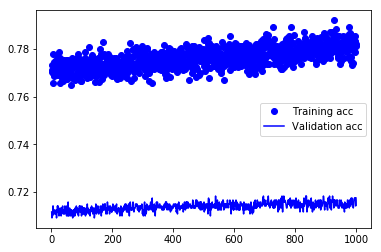

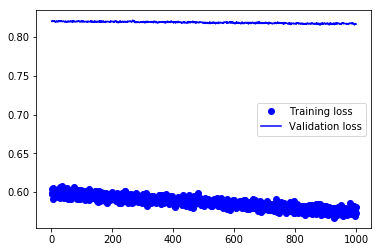

In [26]:
print_graphics (history)